In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from math import atan, atan2
from scipy.interpolate import interp1d
from scipy.linalg import pinv

In [2]:
## my plotting PPI function
def plot_ppi_lidar(azi, distance, variable, timestamp, vmax, vmin,cmap='RdYlBu'):
    # Create a figure and axis
    fig = plt.figure(figsize=(12,9))
    ax = fig.add_subplot()
    axp = fig.add_axes(ax.get_position().bounds, polar=True, frameon=False)
    cax = axp.pcolormesh(azi, distance, variable, cmap=cmap, vmax=vmax, vmin=vmin)

    # Set the title of the plot
    axp.set_title(timestamp)
    axp.set_xticklabels((90, 45, 0, 315, 270, 225, 180, 135))
    axp.set_xticklabels(['', 'NE','', 'NW', '', 'SW', '', 'SE'], fontsize = 15)
    axp.set_yticklabels([])
    # this aligns the Cartesian disntances and the polar plot
    ax.set_aspect('equal')
    ax.set_xlim(-5000,5000)
    ax.set_ylim(-5000,5000)
    ax.set_ylabel("Y (m)")
    ax.set_xlabel("X (m)")
    ax.grid(alpha=0.7)
    axp.set_rlim(0,5000)

    ## plot colorbar
    cax_pos = [axp.get_position().x1 + 0.01, axp.get_position().y0, 0.02, axp.get_position().height]
    colorbar_ax = fig.add_axes(cax_pos)

    # Show the colorbar to indicate the values represented by colors
    cbar = plt.colorbar(cax, cax=colorbar_ax, orientation='vertical',extend="both")
    cbar.ax.set_ylabel("Radial velocity (m/s)")
    save_ts = timestamp.replace(" ", "_").replace(":","_")
    # plt.show()

Maybe just fill the missing values with the nearest neighbours and set a height of the "rectangle"

(or user can input the azimuth to remove)

- for each gate -> find how many nans we have and if nans>60% then cut the above 
- then for all timestamps -> if valid sample number is below 90%? remove the timestamp
- the thresholds may be subject to change

In [3]:
ds = xr.open_dataset("/home/UOCNT/dli84/User1_252_20230727_041816_0_0-463.nc")
intensity = ds["intensity"]

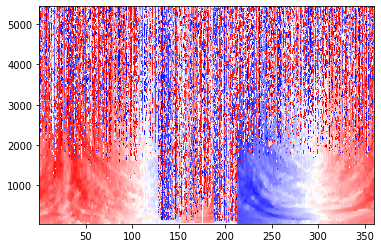

In [4]:
## first check the data
plt.pcolor(np.sort(ds.azimuth), ds.distance, ds.radial_velocity.sortby(ds.azimuth).T,cmap="bwr")

# Step1 - remove unwanted azimuth

In [5]:
## this is for UC library scans
## needs to be changed depending on the scans
## may need a bit of modification if the invalid scans jumps over 0, i.e. from 350 to 10
from_azi_bad = 130
to_azi_bad = 210
bad_data = np.argwhere((from_azi_bad<ds.azimuth.data)&(ds.azimuth.data<to_azi_bad))
## drop the bad azimuth
ds_drop = ds.drop_isel(time=bad_data)

In [6]:
ds_drop.azimuth

<xarray.DataArray 'azimuth' (time: 361)>
array([210.  , 210.  , 210.62, ..., 128.35, 129.11, 129.91])
Coordinates:
  * time       (time) datetime64[ns] 2023-07-27T08:37:04.730004 ... 2023-07-2...
    azimuth    (time) float64 210.0 210.0 210.6 211.4 ... 128.3 129.1 129.9
    elevation  (time) float64 ...
    pitch      (time) float64 ...
    roll       (time) float64 ...

# Step 2 - Use "intensity" (SNR+1) to mask data

In [7]:
## select intensity range
## the "intensity" variable equals SNR+1
from_intensity = 1.01
to_intensity = 1.95
ds_mask = ds_drop.where((1.01<intensity) & (intensity<1.95))

In [8]:
vr_masked = ds_mask["radial_velocity"]

## specify the percentage to cut nans
## in this example, I cut the lowest range gate with more than 60% of NaNs
## and drop each ray with more than 10% of NaNs
cut_nan_percent_h = 0.6
cut_nan_percent_t = 0.1

## find how many nans we have at each range gate
h_nan_idx = []
for i in range(0, len(ds_mask["distance"])):
    ## calculate the percentage
    h_nan_idx.append(len(np.argwhere(np.isnan(vr_masked.data[:,i]))) / len(ds_mask["time"]))
## find where to cut
h_cut_idx1 = np.argwhere(np.array(h_nan_idx)>cut_nan_percent_h)[0][0]
    
## now check along the time coordinate
t_nan_idx = []
for it in range(0, len(ds_mask["time"])):
    ## calculate the percentage 
    t_nan_idx.append(len(np.argwhere(np.isnan(vr_masked.data[it,:h_cut_idx1]))) / len(ds_mask["distance"]))
    
## find where to cut 
t_cut_idx1 = np.argwhere(np.array(t_nan_idx)>cut_nan_percent_t)

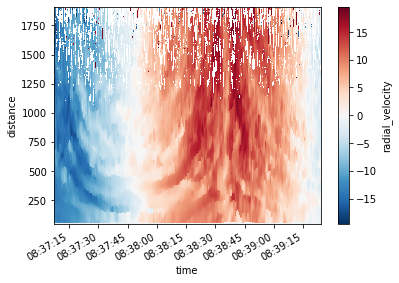

In [9]:
## plotting
vr_masked[:, :h_cut_idx1].drop_isel(time = t_cut_idx1).plot(x = "time")

/tmp/ipykernel_1941584/1385270668.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axp.set_xticklabels((90, 45, 0, 315, 270, 225, 180, 135))
/tmp/ipykernel_1941584/1385270668.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axp.set_xticklabels(['', 'NE','', 'NW', '', 'SW', '', 'SE'], fontsize = 15)


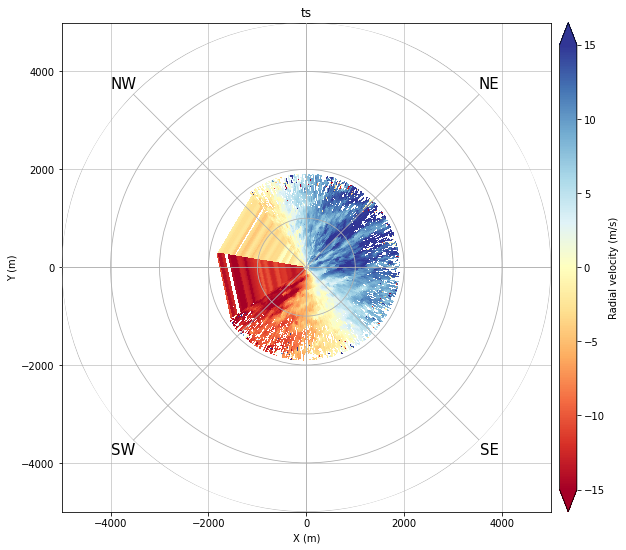

In [10]:
## have xarray dataset with the coordinates cut
## ds_cut would be the end product for imputation and svd
vr_cut = vr_masked[:, :h_cut_idx1].drop_isel(time = t_cut_idx1)
ds_cut = ds_mask.drop_isel(time = t_cut_idx1)
## plot the processed data in polar view
plot_ppi_lidar(np.deg2rad(np.sort(ds_cut.azimuth)), vr_cut.distance, vr_cut.sortby(ds_cut.azimuth).T, "ts", 15, -15)

/tmp/ipykernel_1941584/1385270668.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axp.set_xticklabels((90, 45, 0, 315, 270, 225, 180, 135))
/tmp/ipykernel_1941584/1385270668.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axp.set_xticklabels(['', 'NE','', 'NW', '', 'SW', '', 'SE'], fontsize = 15)


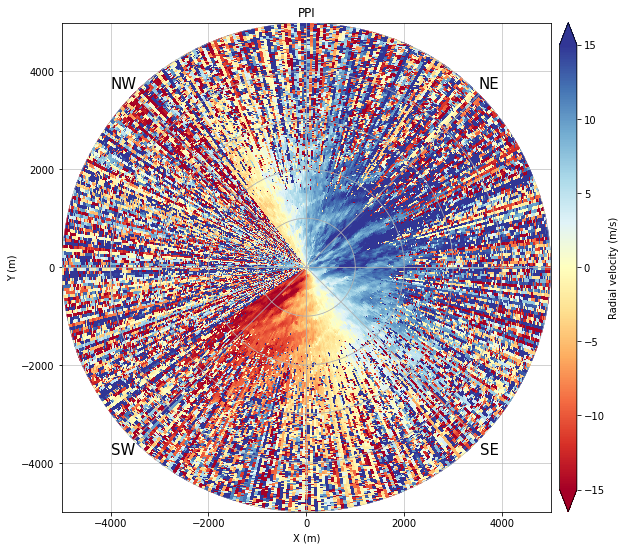

In [11]:
## plot the orignial data
plot_ppi_lidar(np.deg2rad(np.sort(ds.azimuth)), ds.distance, ds.radial_velocity.sortby(ds.azimuth).T, "PPI", 15, -15)